In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/brain-mri-dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [10]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [11]:
train_path = './dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path) # store list of disease types
for directory in directories:
    f_path = os.path.join(train_path, directory) # join filepath with tumor name to get full path
    filelists = os.listdir(f_path) # get all files in list in current f_path
    filepaths.extend([os.path.join(f_path, file) for file in filelists]) # in current f_path add all files in filelist of it
    labels.extend([directory] * len(filelists)) # add label to current directory, number of labels equal to len(filelists)

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [12]:
test_path = './dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path)
for directory in directories:
    f_path = os.path.join(test_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [13]:
img_size = (224, 244)
batch_size = 16

tr_gen = ImageDataGenerator(rotation_range=5,
                            width_shift_range=0.02,
                            height_shift_range=0.02,
                            horizontal_flip=True)

ts_gen = ImageDataGenerator()

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(train_frame)):
    print(f"Fold {fold + 1}")

    train_df = train_frame.iloc[train_index]
    valid_df = train_frame.iloc[val_index]

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet',
                                                                   input_shape=(224, 244, 3), pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer = regularizers.l2(l= 0.015) , activity_regularizer = regularizers.l1(0.005),
        bias_regularizer= regularizers.l1(0.005) , activation = 'relu'),
        Dropout(rate=0.35, seed=42),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=valid_gen, epochs=8, shuffle=True, verbose=1)

    fold_accuracies.append(history.history['val_accuracy'][-1])
    fold_losses.append(history.history['val_loss'][-1])


avg_accuracy = np.mean(fold_accuracies)
avg_loss = np.mean(fold_losses)

var_accuracy = np.var(fold_accuracies)
var_loss = np.var(fold_losses)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Variance in Accuracy: {var_accuracy:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Variance in Loss: {var_loss:.4f}")

Fold 1
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Epoch 1/8
286/286 [==============================] - 156s 376ms/step - loss: 5.1568 - accuracy: 0.8709 - val_loss: 3.4025 - val_accuracy: 0.9064
Epoch 2/8
286/286 [==============================] - 102s 354ms/step - loss: 2.2145 - accuracy: 0.9477 - val_loss: 1.4612 - val_accuracy: 0.9790
Epoch 3/8
286/286 [==============================] - 101s 351ms/step - loss: 1.0585 - accuracy: 0.9626 - val_loss: 0.8086 - val_accuracy: 0.9510
Epoch 4/8
286/286 [==============================] - 102s 357ms/step - loss: 0.5577 - accuracy: 0.9786 - val_loss: 0.3753 - val_accuracy: 0.9834
Epoch 5/8
286/286 [==============================] - 104s 364ms/step - loss: 0.3579 - accuracy: 0.9757 - val_loss: 0.2828 - val_accuracy: 0.9816
Epoch 6/8
286/286 [==============================] - 100s 347ms/step - loss: 0.2687 - accuracy: 0.9794 - val_loss: 0.2057 - val_accuracy: 0.9886
E

In [15]:
full_train_gen = tr_gen.flow_from_dataframe(train_frame, x_col='filepaths', y_col='label', target_size=img_size,
                                            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet',
                                                               input_shape=(224, 244, 3), pooling='max')
model = Sequential([
  base_model,
  BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
  Dense(256, kernel_regularizer = regularizers.l2(l= 0.015) , activity_regularizer = regularizers.l1(0.005),
  bias_regularizer= regularizers.l1(0.005) , activation = 'relu'),
  Dropout(rate=0.35, seed=42),
  Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(Adamax(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(full_train_gen, epochs=8, shuffle=True, verbose=1)

test_gen = ts_gen.flow_from_dataframe(test_frame, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

test_score = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
test_loss, test_accuracy = test_score

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 5712 validated image filenames belonging to 4 classes.
Epoch 1/8
357/357 [==============================] - 170s 334ms/step - loss: 4.8590 - accuracy: 0.8768
Epoch 2/8
357/357 [==============================] - 119s 334ms/step - loss: 1.7335 - accuracy: 0.9592
Epoch 3/8
357/357 [==============================] - 121s 338ms/step - loss: 0.7132 - accuracy: 0.9687
Epoch 4/8
357/357 [==============================] - 123s 344ms/step - loss: 0.3855 - accuracy: 0.9729
Epoch 5/8
357/357 [==============================] - 121s 338ms/step - loss: 0.2749 - accuracy: 0.9788
Epoch 6/8
357/357 [==============================] - 119s 334ms/step - loss: 0.2086 - accuracy: 0.9856
Epoch 7/8
357/357 [==============================] - 121s 339ms/step - loss: 0.1895 - accuracy: 0.9869
Epoch 8/8
357/357 [==============================] - 120s 334ms/step - loss: 0.1582 - accuracy: 0.9897
Found 1311 validated image filenames belonging to 4 classes.
82/82 [==============================] - 9s 87ms/step 

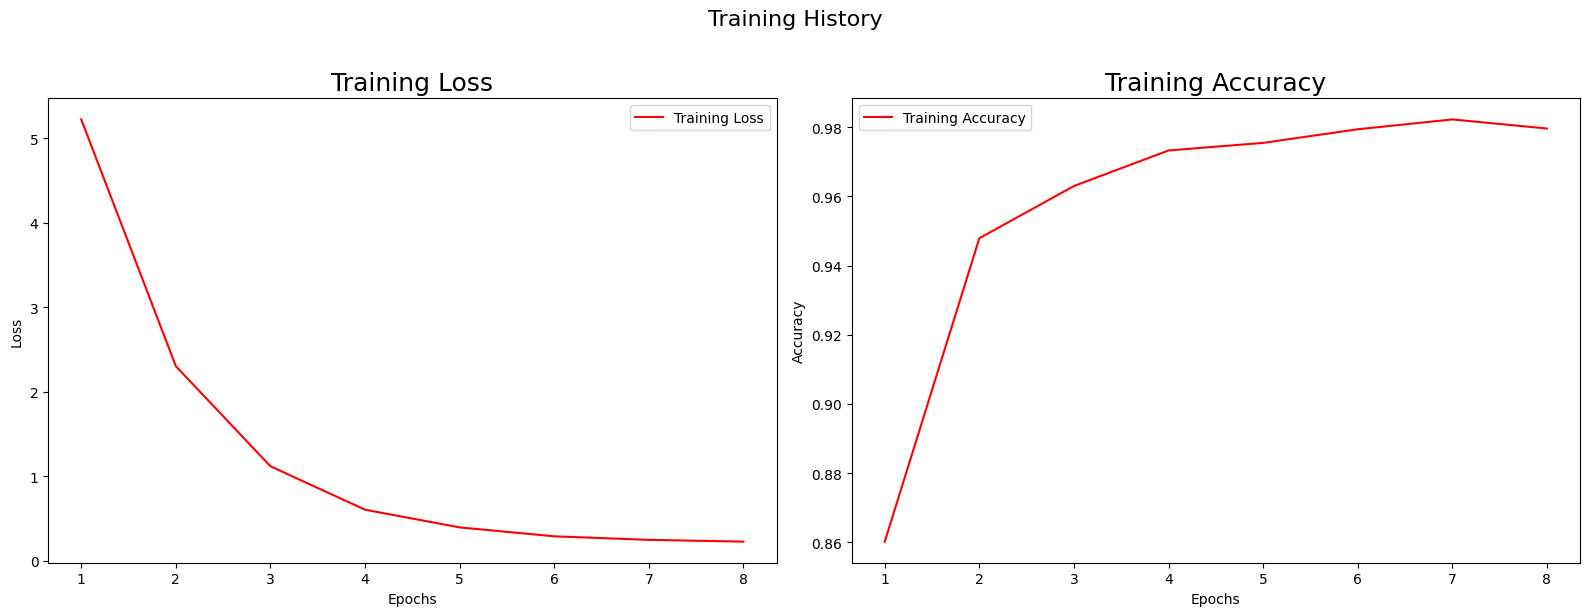

In [16]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

Epochs = [i + 1 for i in range(len(train_acc))]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].set_title('Training Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].set_title('Training Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

82/82 [==============================] - 11s 63ms/step


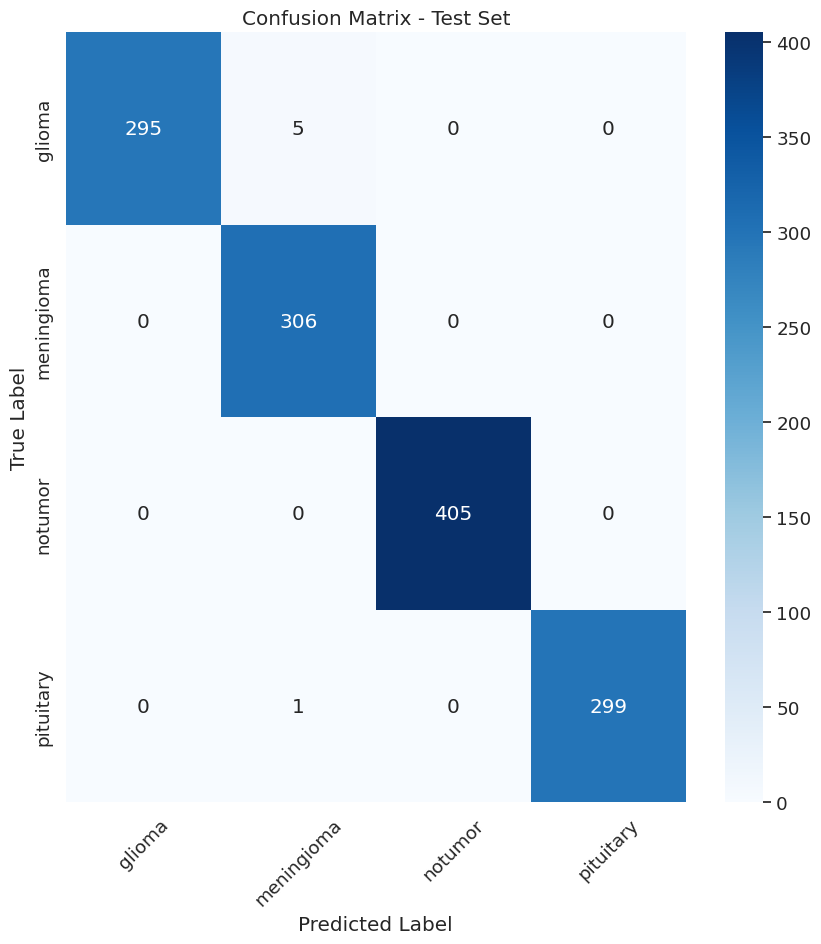

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      0.99      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [17]:
test_preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
test_y_pred = np.argmax(test_preds, axis=1)

test_cm = confusion_matrix(test_gen.classes, test_y_pred)
test_classes = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

print(classification_report(test_gen.classes, test_y_pred, target_names=test_classes))